K-Means Silhouette Score (PCA components): 0.613
Agglomerative Clustering Silhouette Score (PCA components): 0.610
Divisive Hierarchical Clustering Silhouette Score (PCA components): 0.610


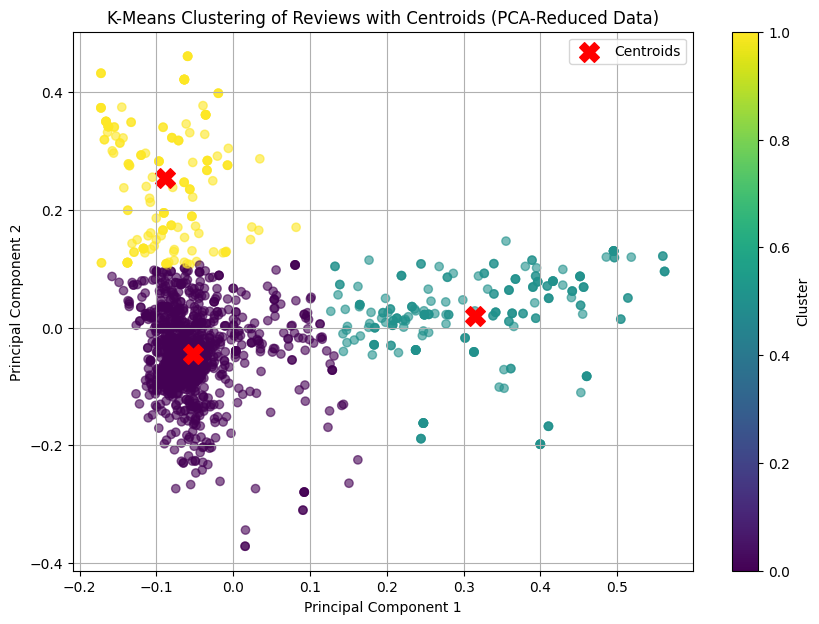

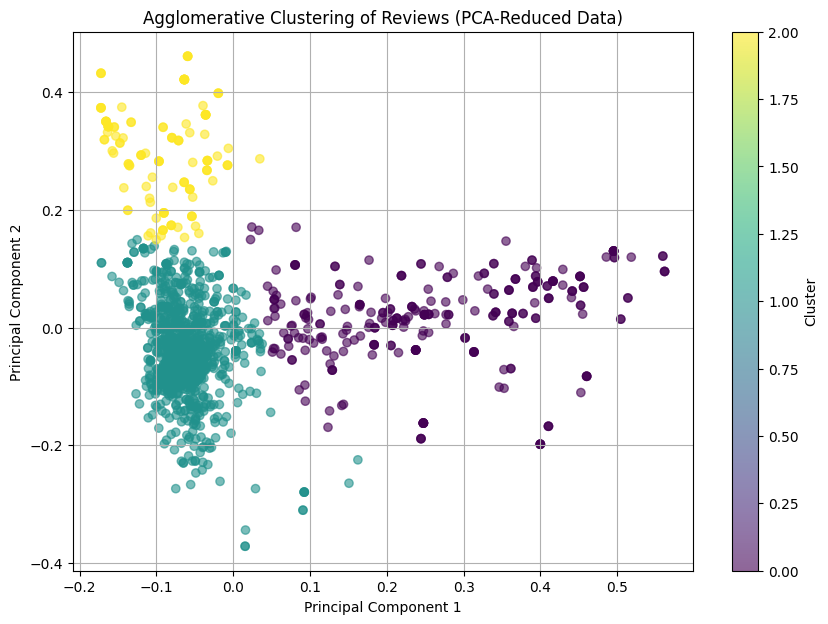

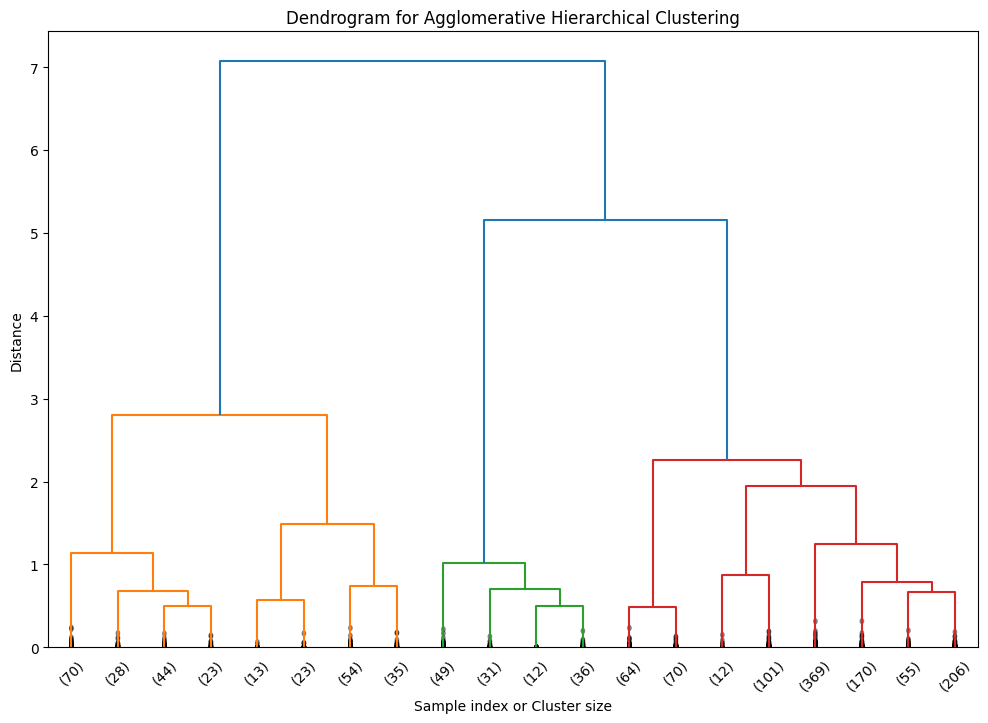

In [4]:
from sklearn.metrics import pairwise_distances_argmin_min
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from textblob import TextBlob
from scipy.cluster.hierarchy import dendrogram, linkage

# Load the data
df = pd.read_csv("amazon.csv")

# Define custom stop words
custom_stop_words = ['the', 'is', 'i', 'in', 'and', 'to', 'of', 'a', 'an', 'it', 'this', 'that', 'for', 'with']

# Preprocess text function
def preprocess_text(text):
    if not isinstance(text, str):
        text = ""
    text = text.lower()
    cleaned_text = ''.join([char if char.isalpha() or char.isspace() else ' ' for char in text])
    cleaned_text = ' '.join([word for word in cleaned_text.split() if word not in custom_stop_words])
    return cleaned_text

# Apply preprocessing to the review content
df['cleaned_review'] = df['review_content'].apply(preprocess_text)

# Vectorize the cleaned review text
vectorizer = TfidfVectorizer(stop_words='english')
x_vec = vectorizer.fit_transform(df['cleaned_review']).toarray()

# Reduce dimensionality with PCA
pca = PCA(n_components=2, random_state=42)
x_pca = pca.fit_transform(x_vec)

#---------------------------- K-Means Clustering ----------------------------

# Apply K-Means clustering on the PCA components
num_clusters = 3  # Adjust the number of clusters as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['cluster_kmeans'] = kmeans.fit_predict(x_pca)

# Calculate the silhouette score for K-Means
silhouette_avg_kmeans = silhouette_score(x_pca, df['cluster_kmeans'])
print(f"K-Means Silhouette Score (PCA components): {silhouette_avg_kmeans:.3f}")

#------------------------ Agglomerative Clustering -------------------------

# Apply Agglomerative Clustering on the PCA components
num_clusters_agg = 3  # Adjust the number of clusters as needed
agg_clustering = AgglomerativeClustering(n_clusters=num_clusters_agg, metric='euclidean', linkage='ward')
df['cluster_agg'] = agg_clustering.fit_predict(x_pca)

# Calculate the silhouette score for Agglomerative Clustering
silhouette_avg_agg = silhouette_score(x_pca, df['cluster_agg'])
print(f"Agglomerative Clustering Silhouette Score (PCA components): {silhouette_avg_agg:.3f}")

#-------------------------- Divisive Hierarchical Clustering ----------------

# Divisive hierarchical clustering using Agglomerative Clustering
num_initial_clusters = 1
desired_clusters = 3
df['cluster_divisive'] = 0  # Initialize with one cluster

while df['cluster_divisive'].nunique() < desired_clusters:
    # Identify the largest cluster
    largest_cluster = df['cluster_divisive'].value_counts().idxmax()
    largest_cluster_data = x_pca[df['cluster_divisive'] == largest_cluster]
    
    # Split the largest cluster into 2 subclusters
    sub_clustering = AgglomerativeClustering(n_clusters=2, linkage='ward')
    sub_clusters = sub_clustering.fit_predict(largest_cluster_data)
    
    # Update the cluster labels for the split clusters
    new_cluster_labels = (sub_clusters + df['cluster_divisive'].max() + 1)
    df.loc[df['cluster_divisive'] == largest_cluster, 'cluster_divisive'] = new_cluster_labels

# Calculate the silhouette score for Divisive Hierarchical Clustering
silhouette_avg_divisive = silhouette_score(x_pca, df['cluster_divisive'])
print(f"Divisive Hierarchical Clustering Silhouette Score (PCA components): {silhouette_avg_divisive:.3f}")

#------------------------------ Visualization -----------------------------


# Visualize the K-Means Clusters with Centroids
plt.figure(figsize=(10, 7))
plt.scatter(x_pca[:, 0], x_pca[:, 1], c=df['cluster_kmeans'], cmap='viridis', alpha=0.6)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='red', label='Centroids', marker='X')
plt.title("K-Means Clustering of Reviews with Centroids (PCA-Reduced Data)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label='Cluster')
plt.legend()
plt.grid()
plt.show()


# Visualize the Agglomerative Clustering
plt.figure(figsize=(10, 7))
plt.scatter(x_pca[:, 0], x_pca[:, 1], c=df['cluster_agg'], cmap='viridis', alpha=0.6)
plt.title("Agglomerative Clustering of Reviews (PCA-Reduced Data)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label='Cluster')
plt.grid()
plt.show()


# Optional: Plot Dendrogram for Agglomerative Clustering
linkage_matrix = linkage(x_pca, method='ward')
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, truncate_mode='lastp', p=20, leaf_rotation=45., leaf_font_size=10., show_contracted=True)
plt.title("Dendrogram for Agglomerative Hierarchical Clustering")
plt.xlabel("Sample index or Cluster size")
plt.ylabel("Distance")
plt.show()

